In [1]:
from scipy.stats import kstest,ttest_ind
import pandas as pd
import numpy as np

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
def get_validation_table(cohort_file, combo_info_file, group):
    cohort_df = pd.read_csv(cohort_file, usecols=["sample_names", "bmi", "bmi_prs"])
    combo_info_df = pd.read_csv(combo_info_file)
    all_combo_samples = set("|".join(combo_info_df.combo_samples.values).split("|"))
    cohort_df["combo_carriers"] = cohort_df.sample_names.astype(str).isin(all_combo_samples)
    cohort_df["group"] = group
    return cohort_df

def get_validation_groups(cohort_files, combo_info_files, groups):
    cohort_dfs = [get_validation_table(cohort_file, combo_info_file, group) for cohort_file, combo_info_file, group in zip(cohort_files, combo_info_files, groups)]
    return pd.concat(cohort_dfs)

In [4]:
cohort_files = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british_male/test_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british_female/test_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/pre_menopause/test_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/post_menopause/test_cohort_bmi.csv.gz",
]

combo_info_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british_male/test_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british_female/test_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/pre_menopause/test_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/post_menopause/test_cohort.csv"
]

groups = ["british_male", "british_female", "pre_menopause", "post_menopause"]

In [5]:
cohort_df = get_validation_groups(cohort_files, combo_info_files, groups)

In [6]:
cohort_df

,sample_names,bmi_prs,bmi,combo_carriers,group
0,1001044,-2.497630,25.87140,False,british_male
1,1002002,-1.327310,24.30910,False,british_male
2,1002119,-0.199478,26.58920,True,british_male
3,1003644,0.687425,34.83810,False,british_male
4,1009415,-0.708952,19.38350,False,british_male
...,...,...,...,...,...
16668,6015845,0.067241,21.20315,False,post_menopause
16669,6019884,-0.681908,24.50790,False,post_menopause
16670,6019946,0.400011,22.80000,False,post_menopause
16671,6024167,0.168653,23.50430,False,post_menopause


/tmp/ipykernel_37018/4186023268.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Male", "Female", "Pre\nmenopause", "Post\nmenopause"], rotation=0, fontsize=18)
/tmp/ipykernel_37018/4186023268.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


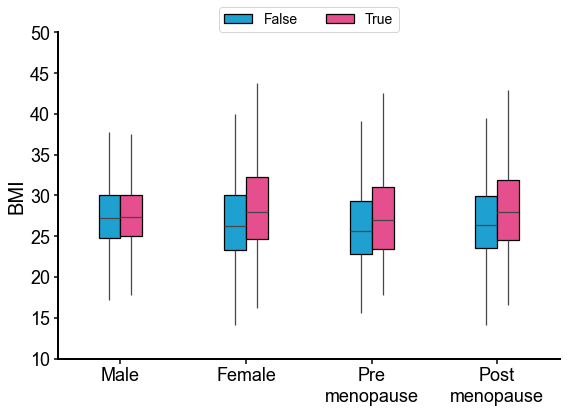

In [7]:
boxdf = cohort_df

fig,ax = plt.subplots(figsize=(9, 6))

# Box Plot
sns_ax = sns.boxplot(
    data=boxdf,
    palette=["#00ADEE", "#FF3688"],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="group",
    y="bmi",
    hue="combo_carriers",
    color="k",
    orient="v",
    legend=True,
    width=0.35, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'} #'facecolor':'none', 
    )

# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
ax.set_ylim((10, 50))
# ax.set_ylabel('Percentage')
ax.set_xticklabels(["Male", "Female", "Pre\nmenopause", "Post\nmenopause"], rotation=0, fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("BMI", fontsize=20)

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# legend below as multiple columns
h,l = sns_ax.axes.get_legend_handles_labels()
sns_ax.axes.legend_.remove()
sns_ax.legend(h,l, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1), fontsize=14)

In [9]:
for g in groups:
    print(f"Running t-test for {g}")
    expected_g = cohort_df.loc[(cohort_df.combo_carriers==False)&(cohort_df.group==g)]
    observed_g = cohort_df.loc[(cohort_df.combo_carriers==True)&(cohort_df.group==g)]
    ttest_res = ttest_ind(expected_g.bmi, observed_g.bmi, alternative="less")
    print(f"TTest results:\tStatistics={ttest_res[0]};p-val={ttest_res[1]}")

Running t-test for british_male
TTest results:	Statistics=-0.7737069996065539;p-val=0.21955562458676953
Running t-test for british_female
TTest results:	Statistics=-12.59756604309494;p-val=1.3332859911348104e-36
Running t-test for pre_menopause
TTest results:	Statistics=-5.744479355947218;p-val=4.761367546707185e-09
Running t-test for post_menopause
TTest results:	Statistics=-11.858496434402262;p-val=1.3110913470082388e-32


In [13]:
cohort_df.loc[(cohort_df.combo_carriers==False)&(cohort_df.group=="british_male"), "bmi"].mean()

27.71368328833655

In [14]:
cohort_df.loc[(cohort_df.combo_carriers==True)&(cohort_df.group=="british_male"), "bmi"].mean()

27.78754729874503

In [17]:
(27.78754729874503-27.71368328833655)/27.71368328833655

0.0026652541865326168